# AML Assignment 5: Part 2 (Sentiment Analysis)

First, we download the dataset from Kaggle.

In [ ]:
!python3 -m pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"codetalker7","key":"ac82aa369636a45b525075f4b32b61ed"}'}

In [ ]:
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                          Spotify and Youtube                                   9MB  2023-03-20 15:43:25          10798        384  1.0              
arnabchaki/data-science-salaries-2023                          Data Science Salaries 2023  💸                        25KB  2023-04-13 09:55:16           4757        114  1.0              
erdemtaha/cancer-data                                          Cancer Data                                          49KB  2023-03-22 07:57:00           5346        108  1.0              
evangower/premier-league-2022-2023                             Pr

In [ ]:
!kaggle datasets download -d abhi8923shriv/sentiment-analysis-dataset

 92% 50.0M/54.4M [00:02<00:00, 34.5MB/s]
100% 54.4M/54.4M [00:02<00:00, 24.6MB/s]


And we extract our dataset.

In [ ]:
!unzip sentiment-analysis-dataset.zip -d sentiment-analysis-dataset/

Archive:  sentiment-analysis-dataset.zip
  inflating: sentiment-analysis-dataset/test.csv  
  inflating: sentiment-analysis-dataset/testdata.manual.2009.06.14.csv  
  inflating: sentiment-analysis-dataset/train.csv  
  inflating: sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv  


Next, we install the required libraries and download a few `nltk` assets.

In [ ]:
!python3 -m pip install transformers
import nltk
nltk.download('movie_reviews')
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.1 MB/s eta 0:00:00


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Next, we import the required modules.

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

We define a function called `mapSentimentToInteger`, which maps `"negative"` to `0`, `"neutral"` to `1` and `"positive"` to `2`; this function will be used to encode the labels.

In [ ]:
def mapSentimentToInteger(sentiment):
    if sentiment == "negative":
        return 0
    elif sentiment == "neutral":
        return 1
    else:
        return 2

Next, we determine the character encoding of the dataset.

In [ ]:
# install the chardet library
!pip install chardet

# import the chardet library
import chardet 

# use the detect method to find the encoding
# 'rb' means read in the file as binary
with open("sentiment-analysis-dataset/train.csv", 'rb') as file:
    print(chardet.detect(file.read()))

with open("sentiment-analysis-dataset/test.csv", 'rb') as file:
    print(chardet.detect(file.read()))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
{'encoding': 'Windows-1252', 'confidence': 0.7294331332807429, 'language': ''}
{'encoding': 'Windows-1252', 'confidence': 0.7296655868590688, 'language': ''}


Next, we create the training, validation and testing datasets.

In [ ]:
sentiment_train_val = pd.read_csv("sentiment-analysis-dataset/train.csv", encoding="Windows-1252", keep_default_na=False)
sentiment_test = pd.read_csv("sentiment-analysis-dataset/test.csv", encoding="Windows-1252",  keep_default_na=False)

sentiment_train_val_text = [sentiment_train_val["text"][i] for i in range(len(sentiment_train_val))]
sentiment_test_text = [sentiment_test["text"][i] for i in range(len(sentiment_test))]

sentiment_train_val_labels = [mapSentimentToInteger(sentiment_train_val["sentiment"][i]) for i in range(len(sentiment_train_val))]
sentiment_test_labels = [mapSentimentToInteger(sentiment_test["sentiment"][i]) for i in range(len(sentiment_test))]

sentiment_train_text, sentiment_val_text, sentiment_train_labels, sentiment_val_labels = train_test_split(sentiment_train_val_text, sentiment_train_val_labels, random_state=2018, test_size=0.3)

In [ ]:
print("Training size:", len(sentiment_train_text))
print("Validation size:", len(sentiment_test_text))
print("Testing size:", len(sentiment_val_text))

Training size: 19236
Validation size: 4815
Testing size: 8245


We now load the pretrained model and tokenizer.

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


To get a sense of the possible maximum length of any sequence length in the dataset, we plot a histogram.

<Axes: >

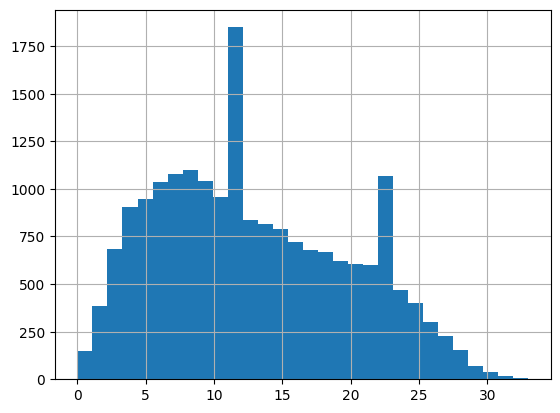

In [ ]:
# get length of all the messages in the train set
seq_len = [len(text.split()) for text in sentiment_train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 25

Using a max length of 25, we tokenize the training, validation and testing data.

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    sentiment_train_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    sentiment_val_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    sentiment_test_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Next, we convert the different components of the datasets to tensors.

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(sentiment_train_labels)

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(sentiment_val_labels)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(sentiment_test_labels)

We now initialize `DataLoader` objects, and also initialize the batch size.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

As before, we will freeze all the parameters of the model.

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

We now define a simple architecture for our model. In this architecture, we will use the preloaded `bert` model.

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,3)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model  
      outputs = self.bert(sent_id, attention_mask=mask).pooler_output
      x = self.fc1(outputs)
      x = self.relu(x)
      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

Next, we initialize our model, and define the loss function and the optimizer.

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(sentiment_train_labels), y=sentiment_train_labels)

print(class_wts)

[1.17737789 0.82247306 1.0697364 ]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

Finally, we define a function which represents one step of training.

In [ ]:
# function to train the model
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    
    # empty list to save model predictions
    total_preds=[]
    
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]
    
        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

We also define a function to evaluate the model on the validation dataset.

In [ ]:
# function for evaluating the model
def evaluate():
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds
     

Finally, we train the model.

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    602.
  Batch   100  of    602.
  Batch   150  of    602.
  Batch   200  of    602.
  Batch   250  of    602.
  Batch   300  of    602.
  Batch   350  of    602.
  Batch   400  of    602.
  Batch   450  of    602.
  Batch   500  of    602.
  Batch   550  of    602.
  Batch   600  of    602.

Evaluating...
  Batch    50  of    258.
  Batch   100  of    258.
  Batch   150  of    258.
  Batch   200  of    258.
  Batch   250  of    258.

Training Loss: 1.121
Validation Loss: 1.099

 Epoch 2 / 10
  Batch    50  of    602.
  Batch   100  of    602.
  Batch   150  of    602.
  Batch   200  of    602.
  Batch   250  of    602.
  Batch   300  of    602.
  Batch   350  of    602.
  Batch   400  of    602.
  Batch   450  of    602.
  Batch   500  of    602.
  Batch   550  of    602.
  Batch   600  of    602.

Evaluating...
  Batch    50  of    258.
  Batch   100  of    258.
  Batch   150  of    258.
  Batch   200  of    258.
  Batch   250  of    258.

Training L

After this, we print the classification report on the test dataset.

In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1001
           1       0.30      1.00      0.46      1430
           2       0.00      0.00      0.00      2384

    accuracy                           0.30      4815
   macro avg       0.10      0.33      0.15      4815
weighted avg       0.09      0.30      0.14      4815



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
